In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import collections # For frequency counting
import findspark
findspark.init("../../spark2")

import pyspark
from pyspark.sql import DataFrameNaFunctions
from pyspark.sql.functions import lit # Create columns of *literal* value
from pyspark.sql.functions import col # Returns a Column based on the 
                                      # given column name
from pyspark.ml.feature import StringIndexer #label encoding
from pyspark.ml import Pipeline

sc = pyspark.SparkContext(appName="helloworld")

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [3]:
trainDF = spark.read.csv("../data/titanic/train.csv", header="true")
testDF = spark.read.csv("../data/titanic/test.csv", header="true")

In [4]:
trainDF.count()

891

**Combine train and test data.**

In [5]:
## Add Survived column to test, and dataset name as a column
trainDF = trainDF.withColumn('Mark', lit('train'))
testDF = (testDF.withColumn('Survived',lit(0))
                .withColumn('Mark', lit('test')))
testDF = testDF[trainDF.columns]

## Append Test data to Train data
df = trainDF.unionAll(testDF)

In [6]:
df.createOrReplaceTempView("train")

In [7]:
df.columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked',
 'Mark']

In [13]:
df.printSchema()

root
 |-- PassengerId: string (nullable = true)
 |-- Survived: string (nullable = true)
 |-- Pclass: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- SibSp: string (nullable = true)
 |-- Parch: string (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: string (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)
 |-- Mark: string (nullable = false)



In [14]:
df.show(5)

+-----------+--------+------+--------------------+------+---+-----+-----+----------------+-------+-----+--------+-----+
|PassengerId|Survived|Pclass|                Name|   Sex|Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked| Mark|
+-----------+--------+------+--------------------+------+---+-----+-----+----------------+-------+-----+--------+-----+
|          1|       0|     3|Braund, Mr. Owen ...|  male| 22|    1|    0|       A/5 21171|   7.25|     |       S|train|
|          2|       1|     1|Cumings, Mrs. Joh...|female| 38|    1|    0|        PC 17599|71.2833|  C85|       C|train|
|          3|       1|     3|Heikkinen, Miss. ...|female| 26|    0|    0|STON/O2. 3101282|  7.925|     |       S|train|
|          4|       1|     1|Futrelle, Mrs. Ja...|female| 35|    1|    0|          113803|   53.1| C123|       S|train|
|          5|       0|     3|Allen, Mr. Willia...|  male| 35|    0|    0|          373450|   8.05|     |       S|train|
+-----------+--------+------+-----------

In [8]:
# Here is an example
df = df.withColumn("AgeTmp", df["Age"].cast("float")) \
    .drop("Age") \
    .withColumnRenamed("AgeTmp", "Age")

In [9]:
# Let's define function
def to_anytype(df, colnames, typename):
    for colname in colnames:
        df = df.withColumn("tmp", df[colname].cast(typename)) \
        .drop(colname) \
        .withColumnRenamed("tmp", colname)
    return(df)

In [10]:
intCols = ['PassengerId', 'Pclass', 'SibSp', 'Parch', 'Survived']
floatCols = ['Age', 'Fare']

df = to_anytype(df, intCols, "integer")
df = to_anytype(df, floatCols, "float")

In [18]:
df.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)
 |-- Mark: string (nullable = false)
 |-- PassengerId: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Age: float (nullable = true)
 |-- Fare: float (nullable = true)



In [19]:
df.take(5)

[Row(Name='Braund, Mr. Owen Harris', Sex='male', Ticket='A/5 21171', Cabin='', Embarked='S', Mark='train', PassengerId=1, Pclass=3, SibSp=1, Parch=0, Survived=0, Age=22.0, Fare=7.25),
 Row(Name='Cumings, Mrs. John Bradley (Florence Briggs Thayer)', Sex='female', Ticket='PC 17599', Cabin='C85', Embarked='C', Mark='train', PassengerId=2, Pclass=1, SibSp=1, Parch=0, Survived=1, Age=38.0, Fare=71.2833023071289),
 Row(Name='Heikkinen, Miss. Laina', Sex='female', Ticket='STON/O2. 3101282', Cabin='', Embarked='S', Mark='train', PassengerId=3, Pclass=3, SibSp=0, Parch=0, Survived=1, Age=26.0, Fare=7.925000190734863),
 Row(Name='Futrelle, Mrs. Jacques Heath (Lily May Peel)', Sex='female', Ticket='113803', Cabin='C123', Embarked='S', Mark='train', PassengerId=4, Pclass=1, SibSp=1, Parch=0, Survived=1, Age=35.0, Fare=53.099998474121094),
 Row(Name='Allen, Mr. William Henry', Sex='male', Ticket='373450', Cabin='', Embarked='S', Mark='train', PassengerId=5, Pclass=3, SibSp=0, Parch=0, Survived=0, A

In [20]:
df.show(5)

+--------------------+------+----------------+-----+--------+-----+-----------+------+-----+-----+--------+----+-------+
|                Name|   Sex|          Ticket|Cabin|Embarked| Mark|PassengerId|Pclass|SibSp|Parch|Survived| Age|   Fare|
+--------------------+------+----------------+-----+--------+-----+-----------+------+-----+-----+--------+----+-------+
|Braund, Mr. Owen ...|  male|       A/5 21171|     |       S|train|          1|     3|    1|    0|       0|22.0|   7.25|
|Cumings, Mrs. Joh...|female|        PC 17599|  C85|       C|train|          2|     1|    1|    0|       1|38.0|71.2833|
|Heikkinen, Miss. ...|female|STON/O2. 3101282|     |       S|train|          3|     3|    0|    0|       1|26.0|  7.925|
|Futrelle, Mrs. Ja...|female|          113803| C123|       S|train|          4|     1|    1|    0|       1|35.0|   53.1|
|Allen, Mr. Willia...|  male|          373450|     |       S|train|          5|     3|    0|    0|       0|35.0|   8.05|
+--------------------+------+---

In [21]:
df.describe('Age').show()

+-------+------------------+
|summary|               Age|
+-------+------------------+
|  count|              1046|
|   mean|29.881137667305726|
| stddev|14.413493211267733|
|    min|              0.17|
|    max|              80.0|
+-------+------------------+



In [22]:
df.describe(['Age', 'Name']).show()

+-------+------------------+--------------------+
|summary|               Age|                Name|
+-------+------------------+--------------------+
|  count|              1046|                1309|
|   mean|29.881137667305726|                null|
| stddev|14.413493211267733|                null|
|    min|              0.17|"Andersson, Mr. A...|
|    max|              80.0|van Melkebeke, Mr...|
+-------+------------------+--------------------+



In [23]:
df.describe(trainDF.columns).show()

+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+------------------+------------------+-----------------+-----+--------+-----+
|summary|      PassengerId|           Survived|            Pclass|                Name|   Sex|               Age|             SibSp|             Parch|            Ticket|             Fare|Cabin|Embarked| Mark|
+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+------------------+------------------+-----------------+-----+--------+-----+
|  count|             1309|               1309|              1309|                1309|  1309|              1046|              1309|              1309|              1309|             1308| 1309|    1309| 1309|
|   mean|            655.0| 0.2612681436210848| 2.294881588999236|                null|  null|29.881137667305726|0.4988540870893812|0.3850267379679144| 249039.1

In [24]:
df.describe(trainDF.columns[1:4]).show()

+-------+-------------------+------------------+--------------------+
|summary|           Survived|            Pclass|                Name|
+-------+-------------------+------------------+--------------------+
|  count|               1309|              1309|                1309|
|   mean| 0.2612681436210848| 2.294881588999236|                null|
| stddev|0.43949364010802755|0.8378360189701275|                null|
|    min|                  0|                 1|"Andersson, Mr. A...|
|    max|                  1|                 3|van Melkebeke, Mr...|
+-------+-------------------+------------------+--------------------+



In [25]:
df.describe(trainDF.columns[5:8]).show()

+-------+------------------+------------------+------------------+
|summary|               Age|             SibSp|             Parch|
+-------+------------------+------------------+------------------+
|  count|              1046|              1309|              1309|
|   mean|29.881137667305726|0.4988540870893812|0.3850267379679144|
| stddev|14.413493211267733|1.0416583905961019|0.8655602753495152|
|    min|              0.17|                 0|                 0|
|    max|              80.0|                 8|                 9|
+-------+------------------+------------------+------------------+



In [26]:
df.describe(trainDF.columns[9:12]).show()

+-------+-----------------+-----+--------+
|summary|             Fare|Cabin|Embarked|
+-------+-----------------+-----+--------+
|  count|             1308| 1309|    1309|
|   mean|33.29547938203228| null|    null|
| stddev|51.75866881037215| null|    null|
|    min|              0.0|     |        |
|    max|         512.3292|    T|       S|
+-------+-----------------+-----+--------+



In [11]:
age_hist = spark.sql(
    "SELECT Age AS age, \
            count(*) AS count \
    FROM train \
    GROUP BY Age \
    ORDER BY Age")
age_hist.show(n=age_hist.count())

+----+-----+
| age|count|
+----+-----+
|null|  263|
|0.17|    1|
|0.33|    1|
|0.42|    1|
|0.67|    1|
|0.75|    3|
|0.83|    3|
|0.92|    2|
|   1|   10|
|  10|    4|
|  11|    4|
|11.5|    1|
|  12|    3|
|  13|    5|
|  14|    8|
|14.5|    2|
|  15|    6|
|  16|   19|
|  17|   20|
|  18|   39|
|18.5|    3|
|  19|   29|
|   2|   12|
|  20|   23|
|20.5|    1|
|  21|   41|
|  22|   43|
|22.5|    1|
|  23|   26|
|23.5|    1|
|  24|   47|
|24.5|    1|
|  25|   34|
|  26|   30|
|26.5|    1|
|  27|   30|
|  28|   32|
|28.5|    3|
|  29|   30|
|   3|    7|
|  30|   40|
|30.5|    2|
|  31|   23|
|  32|   24|
|32.5|    4|
|  33|   21|
|  34|   16|
|34.5|    2|
|  35|   23|
|  36|   31|
|36.5|    2|
|  37|    9|
|  38|   14|
|38.5|    1|
|  39|   20|
|   4|   10|
|  40|   18|
|40.5|    3|
|  41|   11|
|  42|   18|
|  43|    9|
|  44|   10|
|  45|   21|
|45.5|    2|
|  46|    6|
|  47|   14|
|  48|   14|
|  49|    9|
|   5|    5|
|  50|   15|
|  51|    8|
|  52|    6|
|  53|    4|
|  54|   10|

In [13]:
age_hist = spark.sql(
    "SELECT bucket_floor, \
        CONCAT(bucket_floor, ' to ', bucket_ceiling) as bucket_name, \
        count(*) as count \
     FROM ( \
        SELECT floor(Age/5.00)*5 as bucket_floor, \
            floor(Age/5.00)*5 + 5 as bucket_ceiling \
        FROM train \
     ) a \
     GROUP BY 1, 2 \
     ORDER BY 1")

age_hist.show(n=age_hist.count())


+------------+-----------+-----+
|bucket_floor|bucket_name|count|
+------------+-----------+-----+
|        null|       null|  263|
|           0|     0 to 5|   51|
|           5|    5 to 10|   31|
|          10|   10 to 15|   27|
|          15|   15 to 20|  116|
|          20|   20 to 25|  184|
|          25|   25 to 30|  160|
|          30|   30 to 35|  132|
|          35|   35 to 40|  100|
|          40|   40 to 45|   69|
|          45|   45 to 50|   66|
|          50|   50 to 55|   43|
|          55|   55 to 60|   27|
|          60|   60 to 65|   27|
|          65|   65 to 70|    5|
|          70|   70 to 75|    6|
|          75|   75 to 80|    1|
|          80|   80 to 85|    1|
+------------+-----------+-----+



In [14]:
def get_column(df, colname):
    coldata = df.rdd.map(lambda r: r[colname]).collect()
    coldata = ['None' if v is None else v for v in coldata] #replace None values
    return(coldata)

age = get_column(age_hist, "bucket_name")
count = get_column(age_hist, "count")

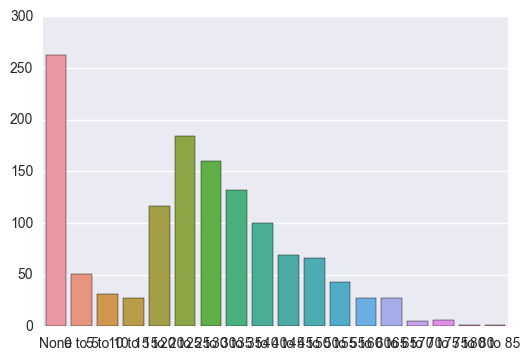

In [15]:
%matplotlib inline

barplt = sns.barplot(age, count)

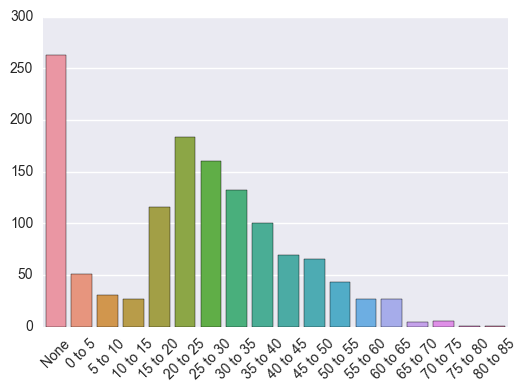

In [16]:
%matplotlib inline

barplt = sns.barplot(age, count)
for item in barplt.get_xticklabels():
    item.set_rotation(45)

In [17]:
def get_column(df, colname):
    coldata = df.rdd.map(lambda r: r[colname]).collect()
    coldata = ['None' if v is None else v for v in coldata] #replace None values
    return(coldata)

def histplot(dfname, colname, binsize):
    binsize = str(binsize)
    dfname.createOrReplaceTempView("tmpDF")
    hist_query = "SELECT bucket_floor, \
        CONCAT(bucket_floor, ' to ', bucket_ceiling) as bucket_name, \
        count(*) as count \
     FROM ( \
        SELECT floor(" + colname + "/" + binsize + ")*" + binsize + " as bucket_floor, \
            floor(" + colname + "/" + binsize + ")*" + binsize + " + " + binsize + " as bucket_ceiling \
        FROM tmpDF \
     ) a \
     GROUP BY 1, 2 \
     ORDER BY 1"
    hist_data = spark.sql(hist_query)
    xvar = get_column(hist_data, "bucket_name")
    count = get_column(hist_data, "count")
    barplt = sns.barplot(xvar, count)
    for item in barplt.get_xticklabels():
        item.set_rotation(45)
    return(barplt)

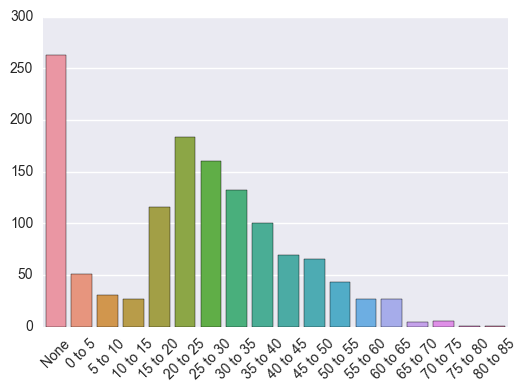

In [18]:
histplot(df, "Age", 5)

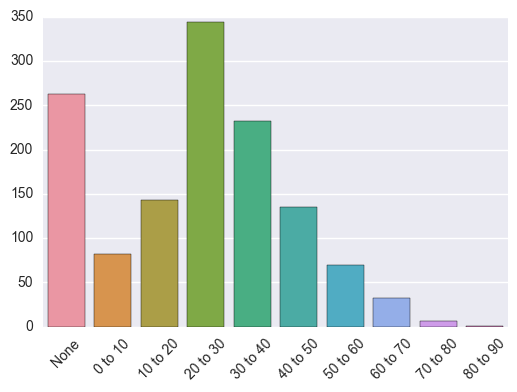

In [19]:
histplot(df, "Age", 10)

In [35]:
df.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)
 |-- Mark: string (nullable = false)
 |-- PassengerId: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Age: float (nullable = true)
 |-- Fare: float (nullable = true)



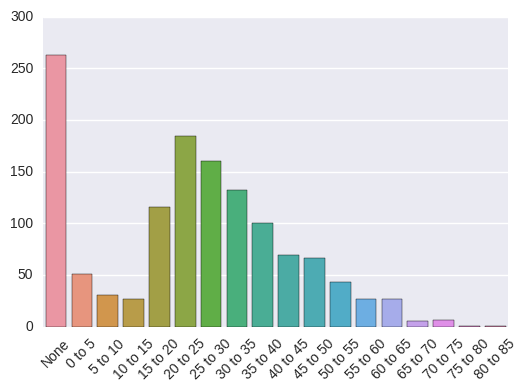

In [36]:
histplot(df, "Age", 5)

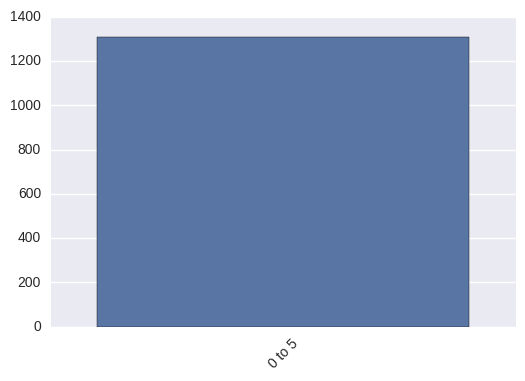

In [37]:
histplot(df, "Survived", 5)

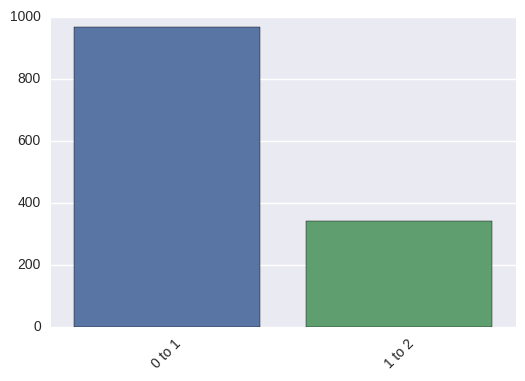

In [38]:
histplot(df, "Survived", 1)

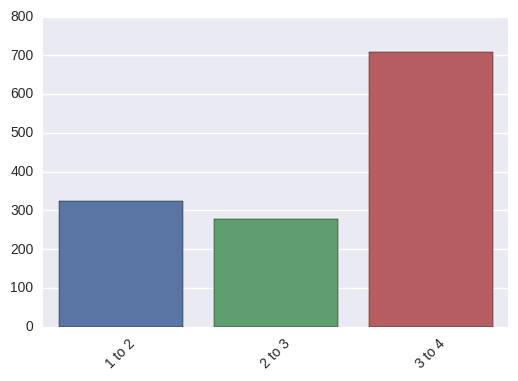

In [39]:
histplot(df, "Pclass", 1)

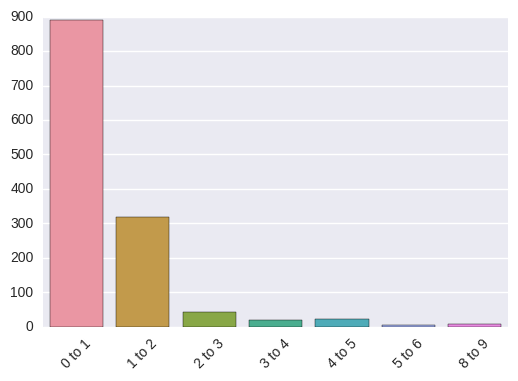

In [40]:
histplot(df, "SibSp", 1)

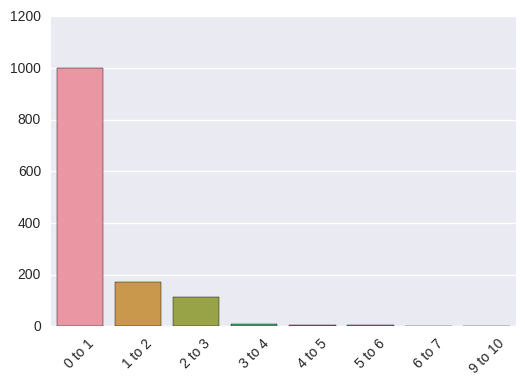

In [41]:
histplot(df, "Parch", 1)

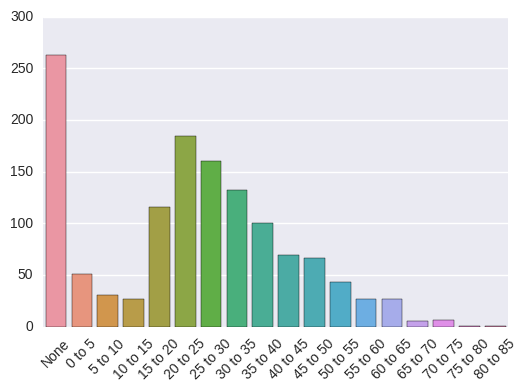

In [42]:
histplot(df, "Age", 5)

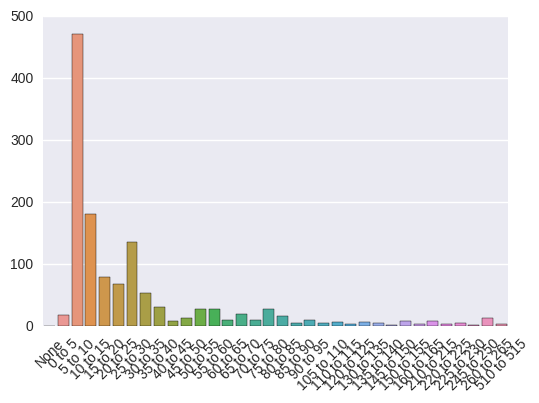

In [43]:
histplot(df, "Fare", 5)

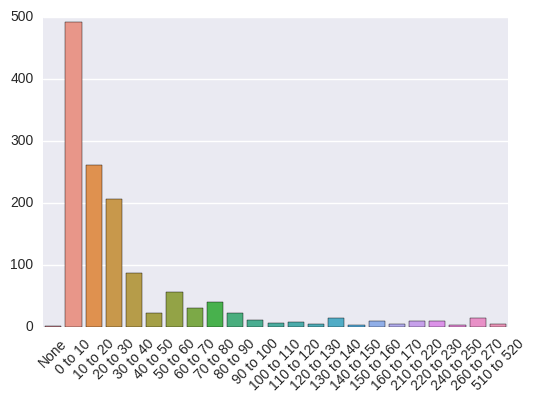

In [44]:
histplot(df, "Fare", 10)

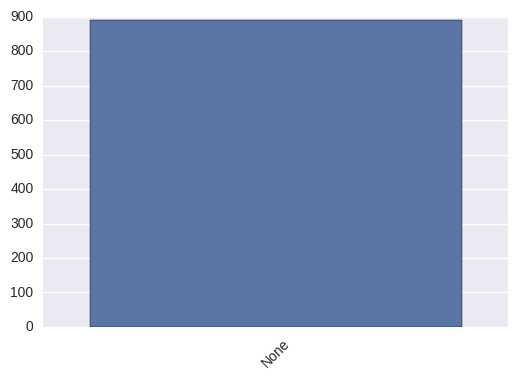

In [45]:
histplot(trainDF, "Embarked", 1)

In [46]:
def histplot_s(df, colname):
    xvar = get_column(df, colname)
    counter = collections.Counter(xvar)
    barplt = sns.barplot(list(counter.keys()), list(counter.values()))
    for item in barplt.get_xticklabels():
        item.set_rotation(45)
    return(barplt)

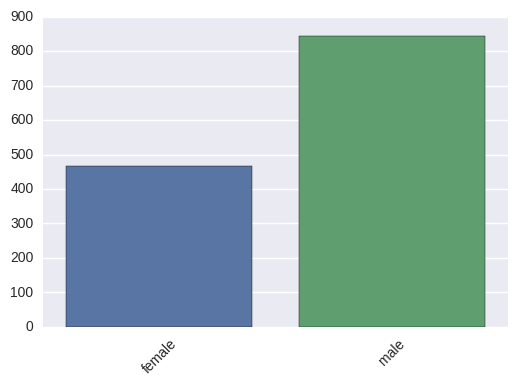

In [47]:
histplot_s(df, "Sex")

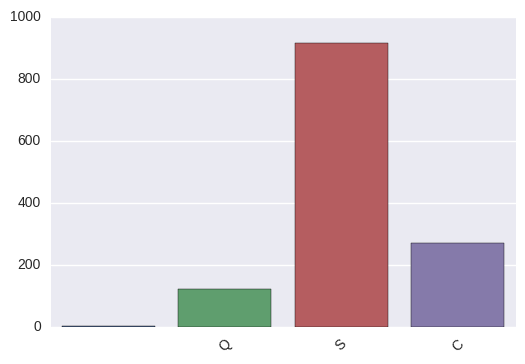

In [48]:
histplot_s(df, "Embarked")

#### Correlations

In [49]:
df.corr("Age", "Fare")

0.21349686667435705

In [50]:
df.corr("Age", "Survived")

0.005296468730662053

In [51]:
df.corr("Fare", "Survived")

0.1738945206553876

In [20]:
numVars = ['Survived','Age','SibSp','Parch','Fare']
stringVars = ['Cabin', 'Embarked', 'Pclass', 'Sex']

def countNull(df,var):
    return df.where(df[var].isNull()).count()

def countEmptyString(df,var):
    return df[df[var].isin("")].count()

def countZero(df,var):
    return df[df[var].isin(0)].count()

In [21]:
missing = {var: countNull(df,var) for var in df.columns}
missing

{'Age': 263,
 'Cabin': 1014,
 'Embarked': 2,
 'Fare': 1,
 'Mark': 0,
 'Name': 0,
 'Parch': 0,
 'PassengerId': 0,
 'Pclass': 0,
 'Sex': 0,
 'SibSp': 0,
 'Survived': 0,
 'Ticket': 0}

In [22]:
missing = {var: countEmptyString(df, var) for var in df.columns}
missing

{'Age': 0,
 'Cabin': 0,
 'Embarked': 0,
 'Fare': 0,
 'Mark': 0,
 'Name': 0,
 'Parch': 0,
 'PassengerId': 0,
 'Pclass': 0,
 'Sex': 0,
 'SibSp': 0,
 'Survived': 0,
 'Ticket': 0}

In [55]:
missing = {var: countZero(df, var) for var in df.columns}
missing

{'Age': 0,
 'Cabin': 0,
 'Embarked': 0,
 'Fare': 17,
 'Mark': 0,
 'Name': 0,
 'Parch': 1002,
 'PassengerId': 0,
 'Pclass': 0,
 'Sex': 0,
 'SibSp': 891,
 'Survived': 967,
 'Ticket': 0}

In [23]:
age_mean = df.groupBy().mean('Age').first()
age_mean

Row(avg(Age)=29.881137667305726)

In [24]:
age_mean[0]

29.881137667305726

In [25]:
age_mean = df.groupBy().mean('Age').first()[0]
fare_mean = df.groupBy().mean('Fare').first()[0]
age_mean, fare_mean

(29.881137667305726, 33.29547938203228)

In [26]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
 
## create user defined function to extract title
getTitle = udf(lambda name: name.split('.')[0].strip(), StringType())
df = df.withColumn('Title', getTitle(df['Name']))
 
df.select('Name','Title').show(5)

+--------------------+---------------+
|                Name|          Title|
+--------------------+---------------+
|Braund, Mr. Owen ...|     Braund, Mr|
|Cumings, Mrs. Joh...|   Cumings, Mrs|
|Heikkinen, Miss. ...|Heikkinen, Miss|
|Futrelle, Mrs. Ja...|  Futrelle, Mrs|
|Allen, Mr. Willia...|      Allen, Mr|
+--------------------+---------------+
only showing top 5 rows



In [27]:
getTitle = udf(lambda name: name.split('.')[0].split(',')[1].strip(), StringType())
df = df.withColumn('Title', getTitle(df['Name']))
 
df.select('Name','Title').show(5)

+--------------------+-----+
|                Name|Title|
+--------------------+-----+
|Braund, Mr. Owen ...|   Mr|
|Cumings, Mrs. Joh...|  Mrs|
|Heikkinen, Miss. ...| Miss|
|Futrelle, Mrs. Ja...|  Mrs|
|Allen, Mr. Willia...|   Mr|
+--------------------+-----+
only showing top 5 rows



In [28]:
catVars = ['Pclass','Sex','Embarked','Title']
 
## index Sex variable
si = StringIndexer(inputCol = 'Sex', outputCol = 'Sex_indexed')
df_indexed = si.fit(df).transform(df).drop('Sex').withColumnRenamed('Sex_indexed','Sex')

In [62]:
df_indexed.show(5)

+--------------------+----------------+-----+--------+-----+-----------+------+-----+-----+--------+----+-------+-----+---+
|                Name|          Ticket|Cabin|Embarked| Mark|PassengerId|Pclass|SibSp|Parch|Survived| Age|   Fare|Title|Sex|
+--------------------+----------------+-----+--------+-----+-----------+------+-----+-----+--------+----+-------+-----+---+
|Braund, Mr. Owen ...|       A/5 21171|     |       S|train|          1|     3|    1|    0|       0|22.0|   7.25|   Mr|0.0|
|Cumings, Mrs. Joh...|        PC 17599|  C85|       C|train|          2|     1|    1|    0|       1|38.0|71.2833|  Mrs|1.0|
|Heikkinen, Miss. ...|STON/O2. 3101282|     |       S|train|          3|     3|    0|    0|       1|26.0|  7.925| Miss|1.0|
|Futrelle, Mrs. Ja...|          113803| C123|       S|train|          4|     1|    1|    0|       1|35.0|   53.1|  Mrs|1.0|
|Allen, Mr. Willia...|          373450|     |       S|train|          5|     3|    0|    0|       0|35.0|   8.05|   Mr|0.0|
+-------

In [29]:
# make use of pipeline to index all categorical variables
def indexer(df, col):
    si = StringIndexer(inputCol = col, outputCol = col+'_indexed').fit(df)
    return si
 
indexers = [indexer(df, col) for col in catVars]

In [43]:
pipeline = Pipeline(stages = indexers)
df_indexed = pipeline.fit(df)
df_indexed = df_indexed.transform(df)
df_indexed.select('Embarked','Embarked_indexed').show(3)

Py4JJavaError: An error occurred while calling o392.transform.
: java.lang.NullPointerException
	at org.apache.spark.sql.types.Metadata$.org$apache$spark$sql$types$Metadata$$hash(Metadata.scala:219)
	at org.apache.spark.sql.types.Metadata$$anonfun$org$apache$spark$sql$types$Metadata$$hash$2.apply(Metadata.scala:207)
	at org.apache.spark.sql.types.Metadata$$anonfun$org$apache$spark$sql$types$Metadata$$hash$2.apply(Metadata.scala:207)
	at scala.collection.TraversableLike$$anonfun$map$1.apply(TraversableLike.scala:234)
	at scala.collection.TraversableLike$$anonfun$map$1.apply(TraversableLike.scala:234)
	at scala.collection.IndexedSeqOptimized$class.foreach(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:35)
	at scala.collection.TraversableLike$class.map(TraversableLike.scala:234)
	at scala.collection.AbstractTraversable.map(Traversable.scala:104)
	at org.apache.spark.sql.types.Metadata$.org$apache$spark$sql$types$Metadata$$hash(Metadata.scala:207)
	at org.apache.spark.sql.types.Metadata$$anonfun$org$apache$spark$sql$types$Metadata$$hash$1.apply(Metadata.scala:204)
	at org.apache.spark.sql.types.Metadata$$anonfun$org$apache$spark$sql$types$Metadata$$hash$1.apply(Metadata.scala:204)
	at scala.collection.MapLike$MappedValues$$anonfun$foreach$3.apply(MapLike.scala:245)
	at scala.collection.MapLike$MappedValues$$anonfun$foreach$3.apply(MapLike.scala:245)
	at scala.collection.TraversableLike$WithFilter$$anonfun$foreach$1.apply(TraversableLike.scala:733)
	at scala.collection.immutable.Map$Map3.foreach(Map.scala:161)
	at scala.collection.TraversableLike$WithFilter.foreach(TraversableLike.scala:732)
	at scala.collection.MapLike$MappedValues.foreach(MapLike.scala:245)
	at scala.util.hashing.MurmurHash3.unorderedHash(MurmurHash3.scala:91)
	at scala.util.hashing.MurmurHash3$.mapHash(MurmurHash3.scala:222)
	at scala.collection.GenMapLike$class.hashCode(GenMapLike.scala:35)
	at scala.collection.AbstractMap.hashCode(Map.scala:59)
	at scala.runtime.ScalaRunTime$.hash(ScalaRunTime.scala:206)
	at org.apache.spark.sql.types.Metadata$.org$apache$spark$sql$types$Metadata$$hash(Metadata.scala:204)
	at org.apache.spark.sql.types.Metadata$$anonfun$org$apache$spark$sql$types$Metadata$$hash$1.apply(Metadata.scala:204)
	at org.apache.spark.sql.types.Metadata$$anonfun$org$apache$spark$sql$types$Metadata$$hash$1.apply(Metadata.scala:204)
	at scala.collection.MapLike$MappedValues$$anonfun$foreach$3.apply(MapLike.scala:245)
	at scala.collection.MapLike$MappedValues$$anonfun$foreach$3.apply(MapLike.scala:245)
	at scala.collection.TraversableLike$WithFilter$$anonfun$foreach$1.apply(TraversableLike.scala:733)
	at scala.collection.immutable.Map$Map1.foreach(Map.scala:116)
	at scala.collection.TraversableLike$WithFilter.foreach(TraversableLike.scala:732)
	at scala.collection.MapLike$MappedValues.foreach(MapLike.scala:245)
	at scala.util.hashing.MurmurHash3.unorderedHash(MurmurHash3.scala:91)
	at scala.util.hashing.MurmurHash3$.mapHash(MurmurHash3.scala:222)
	at scala.collection.GenMapLike$class.hashCode(GenMapLike.scala:35)
	at scala.collection.AbstractMap.hashCode(Map.scala:59)
	at scala.runtime.ScalaRunTime$.hash(ScalaRunTime.scala:206)
	at org.apache.spark.sql.types.Metadata$.org$apache$spark$sql$types$Metadata$$hash(Metadata.scala:204)
	at org.apache.spark.sql.types.Metadata._hashCode$lzycompute(Metadata.scala:107)
	at org.apache.spark.sql.types.Metadata._hashCode(Metadata.scala:107)
	at org.apache.spark.sql.types.Metadata.hashCode(Metadata.scala:108)
	at org.apache.spark.sql.catalyst.expressions.AttributeReference.hashCode(namedExpressions.scala:249)
	at scala.runtime.ScalaRunTime$.hash(ScalaRunTime.scala:206)
	at scala.collection.immutable.HashSet.elemHashCode(HashSet.scala:177)
	at scala.collection.immutable.HashSet.computeHash(HashSet.scala:186)
	at scala.collection.immutable.HashSet.$plus(HashSet.scala:84)
	at scala.collection.immutable.HashSet.$plus(HashSet.scala:35)
	at scala.collection.mutable.SetBuilder.$plus$eq(SetBuilder.scala:22)
	at scala.collection.mutable.SetBuilder.$plus$eq(SetBuilder.scala:20)
	at scala.collection.generic.Growable$class.loop$1(Growable.scala:53)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:57)
	at scala.collection.mutable.SetBuilder.$plus$plus$eq(SetBuilder.scala:20)
	at scala.collection.TraversableLike$class.to(TraversableLike.scala:590)
	at scala.collection.AbstractTraversable.to(Traversable.scala:104)
	at scala.collection.TraversableOnce$class.toSet(TraversableOnce.scala:304)
	at scala.collection.AbstractTraversable.toSet(Traversable.scala:104)
	at org.apache.spark.sql.catalyst.trees.TreeNode.containsChild$lzycompute(TreeNode.scala:89)
	at org.apache.spark.sql.catalyst.trees.TreeNode.containsChild(TreeNode.scala:89)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4$$anonfun$apply$11.apply(TreeNode.scala:335)
	at scala.collection.TraversableLike$$anonfun$map$1.apply(TraversableLike.scala:234)
	at scala.collection.TraversableLike$$anonfun$map$1.apply(TraversableLike.scala:234)
	at scala.collection.immutable.List.foreach(List.scala:381)
	at scala.collection.TraversableLike$class.map(TraversableLike.scala:234)
	at scala.collection.immutable.List.map(List.scala:285)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:334)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:188)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:305)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:275)
	at org.apache.spark.sql.catalyst.plans.QueryPlan$$anonfun$transformExpressionsDown$1.apply(QueryPlan.scala:245)
	at org.apache.spark.sql.catalyst.plans.QueryPlan$$anonfun$transformExpressionsDown$1.apply(QueryPlan.scala:245)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.transformExpression$1(QueryPlan.scala:266)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.org$apache$spark$sql$catalyst$plans$QueryPlan$$recursiveTransform$1(QueryPlan.scala:276)
	at org.apache.spark.sql.catalyst.plans.QueryPlan$$anonfun$6.apply(QueryPlan.scala:285)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:188)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.mapExpressions(QueryPlan.scala:285)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.transformExpressionsDown(QueryPlan.scala:245)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.transformExpressions(QueryPlan.scala:236)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveDeserializer$$anonfun$apply$32.applyOrElse(Analyzer.scala:2031)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveDeserializer$$anonfun$apply$32.applyOrElse(Analyzer.scala:2027)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan$$anonfun$resolveOperators$1.apply(LogicalPlan.scala:61)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan$$anonfun$resolveOperators$1.apply(LogicalPlan.scala:61)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:70)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperators(LogicalPlan.scala:60)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveDeserializer$.apply(Analyzer.scala:2027)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveDeserializer$.apply(Analyzer.scala:2026)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor$$anonfun$execute$1$$anonfun$apply$1.apply(RuleExecutor.scala:85)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor$$anonfun$execute$1$$anonfun$apply$1.apply(RuleExecutor.scala:82)
	at scala.collection.LinearSeqOptimized$class.foldLeft(LinearSeqOptimized.scala:124)
	at scala.collection.immutable.List.foldLeft(List.scala:84)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor$$anonfun$execute$1.apply(RuleExecutor.scala:82)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor$$anonfun$execute$1.apply(RuleExecutor.scala:74)
	at scala.collection.immutable.List.foreach(List.scala:381)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.execute(RuleExecutor.scala:74)
	at org.apache.spark.sql.catalyst.encoders.ExpressionEncoder.resolveAndBind(ExpressionEncoder.scala:258)
	at org.apache.spark.sql.Dataset.<init>(Dataset.scala:209)
	at org.apache.spark.sql.Dataset$.ofRows(Dataset.scala:64)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$withPlan(Dataset.scala:2845)
	at org.apache.spark.sql.Dataset.select(Dataset.scala:1131)
	at org.apache.spark.ml.feature.StringIndexerModel.transform(StringIndexer.scala:185)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)


In [31]:
from pyspark.sql import Row
from pyspark.ml.linalg import DenseVector

In [32]:
catVarsIndexed = [i + '_indexed' for i in catVars]
catVarsIndexed

['Pclass_indexed', 'Sex_indexed', 'Embarked_indexed', 'Title_indexed']

In [33]:
featuresCol = numVars + catVarsIndexed
featuresCol

['Survived',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Pclass_indexed',
 'Sex_indexed',
 'Embarked_indexed',
 'Title_indexed']

In [34]:
featuresCol.remove('Survived')
featuresCol

['Age',
 'SibSp',
 'Parch',
 'Fare',
 'Pclass_indexed',
 'Sex_indexed',
 'Embarked_indexed',
 'Title_indexed']

In [35]:
labelCol = ['Mark','Survived']
labelCol

['Mark', 'Survived']

In [36]:
row = Row('mark','label','features') 
row

<Row(mark, label, features)>

In [37]:
df_indexed = df_indexed[labelCol + featuresCol]
df_indexed

AnalysisException: "cannot resolve '`Pclass_indexed`' given input columns: [Ticket, Pclass, Cabin, Name, Fare, PassengerId, SibSp, Parch, Embarked, Sex, Mark, Age, Title, Survived];;\n'Project [Mark#67, Survived#396, Age#441, SibSp#306, Parch#351, Fare#486, 'Pclass_indexed, 'Sex_indexed, 'Embarked_indexed, 'Title_indexed]\n+- Project [Name#3, Ticket#8, Cabin#10, Embarked#11, Mark#67, PassengerId#216, Pclass#261, SibSp#306, Parch#351, Survived#396, Age#441, Fare#486, Title#1318, Sex_indexed#1351 AS Sex#1383]\n   +- Project [Name#3, Ticket#8, Cabin#10, Embarked#11, Mark#67, PassengerId#216, Pclass#261, SibSp#306, Parch#351, Survived#396, Age#441, Fare#486, Title#1318, Sex_indexed#1351]\n      +- Project [Name#3, Sex#4, Ticket#8, Cabin#10, Embarked#11, Mark#67, PassengerId#216, Pclass#261, SibSp#306, Parch#351, Survived#396, Age#441, Fare#486, Title#1318, UDF(cast(Sex#4 as string)) AS Sex_indexed#1351]\n         +- Project [Name#3, Sex#4, Ticket#8, Cabin#10, Embarked#11, Mark#67, PassengerId#216, Pclass#261, SibSp#306, Parch#351, Survived#396, Age#441, Fare#486, <lambda>(Name#3) AS Title#1318]\n            +- Project [Name#3, Sex#4, Ticket#8, Cabin#10, Embarked#11, Mark#67, PassengerId#216, Pclass#261, SibSp#306, Parch#351, Survived#396, Age#441, Fare#486, <lambda>(Name#3) AS Title#1291]\n               +- Project [Name#3, Sex#4, Ticket#8, Cabin#10, Embarked#11, Mark#67, PassengerId#216, Pclass#261, SibSp#306, Parch#351, Survived#396, Age#441, tmp#456 AS Fare#486]\n                  +- Project [Name#3, Sex#4, Ticket#8, Cabin#10, Embarked#11, Mark#67, PassengerId#216, Pclass#261, SibSp#306, Parch#351, Survived#396, Age#441, tmp#456]\n                     +- Project [Name#3, Sex#4, Ticket#8, Fare#9, Cabin#10, Embarked#11, Mark#67, PassengerId#216, Pclass#261, SibSp#306, Parch#351, Survived#396, Age#441, cast(Fare#9 as float) AS tmp#456]\n                        +- Project [Name#3, Sex#4, Ticket#8, Fare#9, Cabin#10, Embarked#11, Mark#67, PassengerId#216, Pclass#261, SibSp#306, Parch#351, Survived#396, tmp#411 AS Age#441]\n                           +- Project [Name#3, Sex#4, Ticket#8, Fare#9, Cabin#10, Embarked#11, Mark#67, PassengerId#216, Pclass#261, SibSp#306, Parch#351, Survived#396, tmp#411]\n                              +- Project [Name#3, Sex#4, Ticket#8, Fare#9, Cabin#10, Embarked#11, Mark#67, Age#171, PassengerId#216, Pclass#261, SibSp#306, Parch#351, Survived#396, cast(Age#171 as float) AS tmp#411]\n                                 +- Project [Name#3, Sex#4, Ticket#8, Fare#9, Cabin#10, Embarked#11, Mark#67, Age#171, PassengerId#216, Pclass#261, SibSp#306, Parch#351, tmp#366 AS Survived#396]\n                                    +- Project [Name#3, Sex#4, Ticket#8, Fare#9, Cabin#10, Embarked#11, Mark#67, Age#171, PassengerId#216, Pclass#261, SibSp#306, Parch#351, tmp#366]\n                                       +- Project [Survived#1, Name#3, Sex#4, Ticket#8, Fare#9, Cabin#10, Embarked#11, Mark#67, Age#171, PassengerId#216, Pclass#261, SibSp#306, Parch#351, cast(Survived#1 as int) AS tmp#366]\n                                          +- Project [Survived#1, Name#3, Sex#4, Ticket#8, Fare#9, Cabin#10, Embarked#11, Mark#67, Age#171, PassengerId#216, Pclass#261, SibSp#306, tmp#321 AS Parch#351]\n                                             +- Project [Survived#1, Name#3, Sex#4, Ticket#8, Fare#9, Cabin#10, Embarked#11, Mark#67, Age#171, PassengerId#216, Pclass#261, SibSp#306, tmp#321]\n                                                +- Project [Survived#1, Name#3, Sex#4, Parch#7, Ticket#8, Fare#9, Cabin#10, Embarked#11, Mark#67, Age#171, PassengerId#216, Pclass#261, SibSp#306, cast(Parch#7 as int) AS tmp#321]\n                                                   +- Project [Survived#1, Name#3, Sex#4, Parch#7, Ticket#8, Fare#9, Cabin#10, Embarked#11, Mark#67, Age#171, PassengerId#216, Pclass#261, tmp#276 AS SibSp#306]\n                                                      +- Project [Survived#1, Name#3, Sex#4, Parch#7, Ticket#8, Fare#9, Cabin#10, Embarked#11, Mark#67, Age#171, PassengerId#216, Pclass#261, tmp#276]\n                                                         +- Project [Survived#1, Name#3, Sex#4, SibSp#6, Parch#7, Ticket#8, Fare#9, Cabin#10, Embarked#11, Mark#67, Age#171, PassengerId#216, Pclass#261, cast(SibSp#6 as int) AS tmp#276]\n                                                            +- Project [Survived#1, Name#3, Sex#4, SibSp#6, Parch#7, Ticket#8, Fare#9, Cabin#10, Embarked#11, Mark#67, Age#171, PassengerId#216, tmp#231 AS Pclass#261]\n                                                               +- Project [Survived#1, Name#3, Sex#4, SibSp#6, Parch#7, Ticket#8, Fare#9, Cabin#10, Embarked#11, Mark#67, Age#171, PassengerId#216, tmp#231]\n                                                                  +- Project [Survived#1, Pclass#2, Name#3, Sex#4, SibSp#6, Parch#7, Ticket#8, Fare#9, Cabin#10, Embarked#11, Mark#67, Age#171, PassengerId#216, cast(Pclass#2 as int) AS tmp#231]\n                                                                     +- Project [Survived#1, Pclass#2, Name#3, Sex#4, SibSp#6, Parch#7, Ticket#8, Fare#9, Cabin#10, Embarked#11, Mark#67, Age#171, tmp#186 AS PassengerId#216]\n                                                                        +- Project [Survived#1, Pclass#2, Name#3, Sex#4, SibSp#6, Parch#7, Ticket#8, Fare#9, Cabin#10, Embarked#11, Mark#67, Age#171, tmp#186]\n                                                                           +- Project [PassengerId#0, Survived#1, Pclass#2, Name#3, Sex#4, SibSp#6, Parch#7, Ticket#8, Fare#9, Cabin#10, Embarked#11, Mark#67, Age#171, cast(PassengerId#0 as int) AS tmp#186]\n                                                                              +- Project [PassengerId#0, Survived#1, Pclass#2, Name#3, Sex#4, SibSp#6, Parch#7, Ticket#8, Fare#9, Cabin#10, Embarked#11, Mark#67, AgeTmp#141 AS Age#171]\n                                                                                 +- Project [PassengerId#0, Survived#1, Pclass#2, Name#3, Sex#4, SibSp#6, Parch#7, Ticket#8, Fare#9, Cabin#10, Embarked#11, Mark#67, AgeTmp#141]\n                                                                                    +- Project [PassengerId#0, Survived#1, Pclass#2, Name#3, Sex#4, Age#5, SibSp#6, Parch#7, Ticket#8, Fare#9, Cabin#10, Embarked#11, Mark#67, cast(Age#5 as float) AS AgeTmp#141]\n                                                                                       +- Union\n                                                                                          :- Project [PassengerId#0, Survived#1, Pclass#2, Name#3, Sex#4, Age#5, SibSp#6, Parch#7, Ticket#8, Fare#9, Cabin#10, Embarked#11, Mark#67]\n                                                                                          :  +- Project [PassengerId#0, Survived#1, Pclass#2, Name#3, Sex#4, Age#5, SibSp#6, Parch#7, Ticket#8, Fare#9, Cabin#10, Embarked#11, train AS Mark#67]\n                                                                                          :     +- Relation[PassengerId#0,Survived#1,Pclass#2,Name#3,Sex#4,Age#5,SibSp#6,Parch#7,Ticket#8,Fare#9,Cabin#10,Embarked#11] csv\n                                                                                          +- Project [PassengerId#25, cast(Survived#82 as string) AS Survived#125, Pclass#26, Name#27, Sex#28, Age#29, SibSp#30, Parch#31, Ticket#32, Fare#33, Cabin#34, Embarked#35, Mark#96]\n                                                                                             +- Project [PassengerId#25, Survived#82, Pclass#26, Name#27, Sex#28, Age#29, SibSp#30, Parch#31, Ticket#32, Fare#33, Cabin#34, Embarked#35, Mark#96]\n                                                                                                +- Project [PassengerId#25, Pclass#26, Name#27, Sex#28, Age#29, SibSp#30, Parch#31, Ticket#32, Fare#33, Cabin#34, Embarked#35, Survived#82, test AS Mark#96]\n                                                                                                   +- Project [PassengerId#25, Pclass#26, Name#27, Sex#28, Age#29, SibSp#30, Parch#31, Ticket#32, Fare#33, Cabin#34, Embarked#35, 0 AS Survived#82]\n                                                                                                      +- Relation[PassengerId#25,Pclass#26,Name#27,Sex#28,Age#29,SibSp#30,Parch#31,Ticket#32,Fare#33,Cabin#34,Embarked#35] csv\n"

In [38]:
# 0-mark, 1-label, 2-features
# map features to DenseVector
lf = df_indexed.rdd.map(lambda r: (row(r[0], r[1],DenseVector(r[2:])))).toDF()
lf.show()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 124.0 failed 1 times, most recent failure: Lost task 0.0 in stage 124.0 (TID 3370, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/soumendra/github/spark/spark2/python/lib/pyspark.zip/pyspark/worker.py", line 174, in main
    process()
  File "/Users/soumendra/github/spark/spark2/python/lib/pyspark.zip/pyspark/worker.py", line 169, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/Users/soumendra/github/spark/spark2/python/lib/pyspark.zip/pyspark/serializers.py", line 268, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "../../spark2/python/pyspark/rdd.py", line 1338, in takeUpToNumLeft
    yield next(iterator)
  File "<ipython-input-38-c37408dada19>", line 3, in <lambda>
  File "/Users/soumendra/github/spark/spark2/python/lib/pyspark.zip/pyspark/ml/linalg/__init__.py", line 278, in __init__
    ar = np.array(ar, dtype=np.float64)
ValueError: could not convert string to float: 'S'

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:322)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1435)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1423)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1422)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1422)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1650)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1605)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1594)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:628)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1925)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1938)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1951)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:441)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/soumendra/github/spark/spark2/python/lib/pyspark.zip/pyspark/worker.py", line 174, in main
    process()
  File "/Users/soumendra/github/spark/spark2/python/lib/pyspark.zip/pyspark/worker.py", line 169, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/Users/soumendra/github/spark/spark2/python/lib/pyspark.zip/pyspark/serializers.py", line 268, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "../../spark2/python/pyspark/rdd.py", line 1338, in takeUpToNumLeft
    yield next(iterator)
  File "<ipython-input-38-c37408dada19>", line 3, in <lambda>
  File "/Users/soumendra/github/spark/spark2/python/lib/pyspark.zip/pyspark/ml/linalg/__init__.py", line 278, in __init__
    ar = np.array(ar, dtype=np.float64)
ValueError: could not convert string to float: 'S'

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:322)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [39]:
# index label
# convert numeric label to categorical, which is required by
# decisionTree and randomForest
lf = StringIndexer(inputCol = 'label', outputCol='index').fit(lf).transform(lf)
 
lf.show(3)

NameError: name 'lf' is not defined

In [40]:
train = lf.where(lf.mark =='train')
test = lf.where(lf.mark =='test')

NameError: name 'lf' is not defined

In [75]:
test.show(5)

+----+-----+--------------------+-----+
|mark|label|            features|index|
+----+-----+--------------------+-----+
|test|    0|[34.5,0.0,0.0,7.8...|  0.0|
|test|    0|[47.0,1.0,0.0,7.0...|  0.0|
|test|    0|[62.0,0.0,0.0,9.6...|  0.0|
|test|    0|[27.0,0.0,0.0,8.6...|  0.0|
|test|    0|[22.0,1.0,1.0,12....|  0.0|
+----+-----+--------------------+-----+
only showing top 5 rows



In [41]:
# random split further to get train/validate
train, validate = train.randomSplit([0.7,0.3], seed =121)

NameError: name 'train' is not defined

In [80]:
print('Train Data Number of Row: '+ str(train.count()))
print('Validate Data Number of Row: '+ str(validate.count()))
print('Test Data Number of Row: '+ str(test.count()))

Train Data Number of Row: 637
Validate Data Number of Row: 254
Test Data Number of Row: 418


In [84]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
 
dt = DecisionTreeClassifier(maxDepth = 3, labelCol ='index').fit(train)
rf = RandomForestClassifier(numTrees = 100, labelCol = 'index').fit(train)
gbt = GBTClassifier(maxIter = 10, labelCol = 'index').fit(train)


In [86]:
model= rf.transform(test)

In [87]:
model.show(40)


+----+-----+--------------------+-----+--------------------+--------------------+----------+
|mark|label|            features|index|       rawPrediction|         probability|prediction|
+----+-----+--------------------+-----+--------------------+--------------------+----------+
|test|    0|[34.5,0.0,0.0,7.8...|  0.0|[87.7612105029771...|[0.87761210502977...|       0.0|
|test|    0|[47.0,1.0,0.0,7.0...|  0.0|[46.7849487558951...|[0.46784948755895...|       1.0|
|test|    0|[62.0,0.0,0.0,9.6...|  0.0|[88.4204708284241...|[0.88420470828424...|       0.0|
|test|    0|[27.0,0.0,0.0,8.6...|  0.0|[85.6010288453967...|[0.85601028845396...|       0.0|
|test|    0|[22.0,1.0,1.0,12....|  0.0|[46.4935373685879...|[0.46493537368587...|       1.0|
|test|    0|[14.0,0.0,0.0,9.2...|  0.0|[87.1241720127222...|[0.87124172012722...|       0.0|
|test|    0|[30.0,0.0,0.0,7.6...|  0.0|[39.5319375429854...|[0.39531937542985...|       1.0|
|test|    0|[26.0,1.0,1.0,29....|  0.0|[82.4839866234334...|[0.8248398

In [89]:
model.toPandas().to_csv('submission_titanic.csv')